# Who's that Pokémon : CNN from Scratch

By: Nathan Yao <br>
Github: https://github.com/nathanyao13

___

## Background:

For image classification, a common machine learning model to use is a Convolutional Neural Network (CNN). CNNs are especially powerful for tasks involving visual data, as they are designed to capture spatial hierarchies and patterns through the use of convolutional filters.

CNNs operate by applying small filters or kernels across the input image to detect low-level features such as edges, corners, and textures in the early layers, and progressively higher-level features (e.g. shapes or object parts) in deeper layers. These learned filters are optimized during training to minimize classification error.

Below is a diagram showing several common convolutional filters and how they affect an image. Each filter is a 3×3 matrix that is convolved with the input to highlight certain visual patterns—like identity (which preserves the image), edge detection (which highlights transitions), and sharpening (which enhances detail).

![Kernel](https://imgur.com/U2V2SAZ.png)

In this project, I implemented a CNN from scratch using the PyTorch Library, building up layers such as convolutional layers, ReLU activations, max pooling, and fully connected layers to form a complete deep learning pipeline.

More specifically, the goal of this project is to predict the main type of a Pokémon (e.g., Fire, Water, or Grass) given its artwork. 

This project demonstrates how a fundamental CNN can learn to distinguish between different Pokémon types based purely on visual features—offering insight into how computers “see” and learn visual patterns.

___

## Imports

In [365]:
import torch
import torchvision
import torch.nn as nn 
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
from dataset_class import PokemonImages
import torch.backends.cudnn as cudnn
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
import os
from tempfile import TemporaryDirectory

cudnn.benchmark = True

___

## Data Preperation

In [366]:
df = pd.read_csv('pokemon.csv')
df[['english_name','is_legendary','image_path']].head()

,english_name,is_legendary,image_path
0,bulbasaur,0,pokemon_images/Bulbasaur.jpg
1,ivysaur,0,pokemon_images/Ivysaur.jpg
2,venusaur,0,pokemon_images/Venusaur.jpg
3,charmander,0,pokemon_images/Charmander.jpg
4,charmeleon,0,pokemon_images/Charmeleon.jpg


### Classifying if a Pokémon is Legendary: 

In [367]:
df = df[df['primary_type'].isin(['fire', 'water', 'grass'])]
df['main_type'] = df['primary_type'].str.strip()

In [368]:
label_encoder = LabelEncoder()
df['type_label'] = label_encoder.fit_transform(df['main_type'])  
num_classes = len(label_encoder.classes_)
print("Classes:", label_encoder.classes_)  

Classes: ['fire' 'grass' 'water']


In [369]:
train_df, val_df = train_test_split(df, test_size=0.2, 
                                    stratify=df['type_label'], 
                                    random_state = 13)

### Loading Data

In [370]:
augmented_trans = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10), 
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),           
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                     std=[0.5, 0.5, 0.5])])
trans = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64, 64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                     std=[0.5, 0.5, 0.5])])

In [371]:
train_dataset = PokemonImages(df = train_df, label = "type_label", transform=augmented_trans)
val_dataset = PokemonImages(df = val_df, label = "type_label", transform=trans)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

In [372]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cpu device


___

## CNN Architecture

In [373]:
class PokemonCNN(nn.Module):
    def __init__(self, num_classes=18):  
        super(PokemonCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),                             

            nn.Conv2d(32, 64, kernel_size=3, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),                             

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),                             

            nn.Conv2d(128, 256, kernel_size=1),          
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),                             
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),                                
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [374]:
cnn = PokemonCNN(num_classes = num_classes)
cnn

PokemonCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU

### Architecture Explanation:

The design of this CNN was guided by the goal of capturing increasingly complex features as the learning progresses through deeper layers.

The model consists of four convolutional layers, each designed to extract meaningful features from the input Pokémon image. These convolutional layers are each followed by a ReLU activation and Max Pooling operation.  <br>

• **ReLU** (Rectified Linear Unit) introduces non-linearity, enabling the network to learn more complex and abstract patterns beyond simple linear relationships. 
 
• **Max Pooling** reduces the spatial dimensions of the feature maps by selecting the maximum value from local regions. This operation has two main benefits:  
 1. It reduces computational load and the number of trainable parameters.  
 2. It provides translation invariance, which helps the model be protected from (slightly) noisy inputs.

Here is a diagram illustrating the Max Pooling operation:

![Max Pooling](https://imgur.com/aCLbAux.png)

After the convolutional layers, the output is flattened and passed through two fully connected layers. These layers combine the spatial features learned by the CNN and produce the final probability distribution over the Pokémon types.

___

## Training

In [375]:
# Cross Entropy Loss for multiple classes
criterion = nn.CrossEntropyLoss()

# Can change with fine tuning
optimizer = optim.SGD(cnn.parameters(), lr=0.01, momentum=0.9)

# Use scheduler with SGD for sensitivity
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

### Training Function

In [376]:
def train_model(model, criterion, optimizer, scheduler = None, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # training mode
                else:
                    model.eval()   # eval mode

                running_loss = 0.0
                running_corrects = 0

                # iterating through data
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.long().to(device)

                    # zero the parameter gradients every iteration
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # SGD for backwards
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                
                if phase == 'train' and scheduler != None:
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights based on validation results
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

In [377]:
final_model = train_model(cnn, criterion, optimizer,
                         lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.0317 Acc: 0.4648
val Loss: 1.0223 Acc: 0.4630

Epoch 1/24
----------
train Loss: 1.2107 Acc: 0.5869
val Loss: 0.8972 Acc: 0.4630

Epoch 2/24
----------
train Loss: 0.7320 Acc: 0.6667
val Loss: 0.7335 Acc: 0.6481

Epoch 3/24
----------
train Loss: 0.8193 Acc: 0.6808
val Loss: 1.0437 Acc: 0.4630

Epoch 4/24
----------
train Loss: 0.9928 Acc: 0.6761
val Loss: 0.8600 Acc: 0.6481

Epoch 5/24
----------
train Loss: 0.7338 Acc: 0.6620
val Loss: 0.6825 Acc: 0.6852

Epoch 6/24
----------
train Loss: 0.6146 Acc: 0.7700
val Loss: 0.7583 Acc: 0.7963

Epoch 7/24
----------
train Loss: 0.7904 Acc: 0.7183
val Loss: 0.5787 Acc: 0.8519

Epoch 8/24
----------
train Loss: 0.6492 Acc: 0.7606
val Loss: 0.5486 Acc: 0.7778

Epoch 9/24
----------
train Loss: 0.5948 Acc: 0.7512
val Loss: 0.5594 Acc: 0.7778

Epoch 10/24
----------
train Loss: 0.5623 Acc: 0.7559
val Loss: 0.5472 Acc: 0.7963

Epoch 11/24
----------
train Loss: 0.5821 Acc: 0.7887
val Loss: 0.5364 Acc: 0.8148

Ep

___

## Visualizing Results

In [378]:
def visualize_random_samples(model, num_images=6):
    model.eval()
    fig = plt.figure(figsize=(10, 10))

    indices = random.sample(range(len(val_dataset)), num_images)

    for i, idx in enumerate(indices):
        img_tensor, label = val_dataset[idx]
        label = int(label)

        input_tensor = img_tensor.unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(input_tensor)
            pred = int(torch.argmax(output, dim=1).item())

        # Load original image from file path
        img_path = val_dataset.df.iloc[idx]["image_path"]
        img_disp = mpimg.imread(img_path)

        true_type = label_encoder.inverse_transform([label])[0]
        pred_type = label_encoder.inverse_transform([pred])[0]

        ax = plt.subplot((num_images + 1) // 2, 2, i + 1)
        ax.axis('off')
        ax.set_title(f'Pred: {pred_type}, True: {true_type}')
        ax.imshow(img_disp)

    plt.tight_layout()
    plt.show()

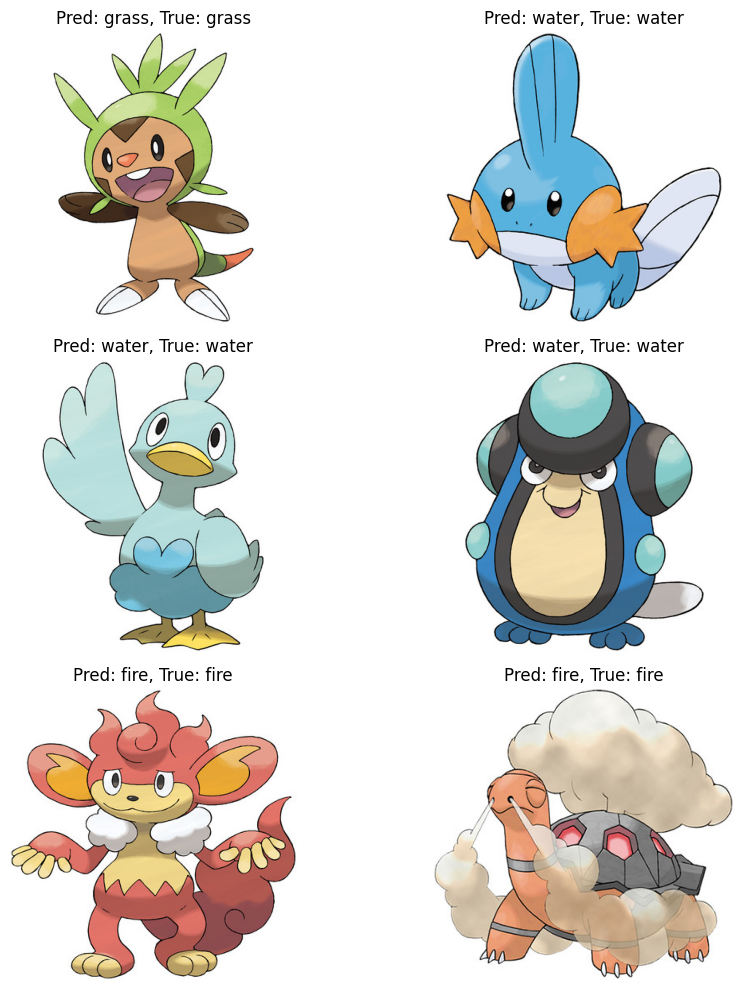

In [379]:
visualize_random_samples(final_model)

___

## Conclusion

### Results:

**3 Type Classification**: <br>
    - Time to Train: 0m 28s <br>
    - Best Validation Accuracy: 85.19% <br>

**18 Type Classification**:<br>
    - Time to Train: 1m 23s <br>
    - Best Validation Accuracy: 34.44% <br>

(Note: These results all have standard deviations due to randomness) <br>


**Fine-Tuning Still in Progress.** <br>
**Analysis and Conclusions coming soon...**